# Lyrics generation using PyTorch

This notebook is largly (laaaaaaaaargly!) inspired by [Cezanne Camacho's notebook](https://github.com/udacity/deep-learning-v2-pytorch/blob/master/recurrent-neural-networks/char-rnn/Character_Level_RNN_Solution.ipynb).

In this notebook, we will try to create and train a model to generate lyrics.

In [222]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import random

import matplotlib.pyplot as plt
%matplotlib inline

## Prepare data

First, let's explore our data and see its structure.

In [223]:
import pandas as pd

file = pd.read_csv("data/songdata.csv")
file.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \nAnd..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \nTouch me gentl..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \nWhy I had t...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


What interests us the most here is the 'text' field. Our model will be training on it. After, we can choose to train a model on the texts of a specific artist.

But before starting, let's have some fun and define a function that will print a random song each time.

In [224]:
def print_random_song():
    n = len(file)
    song = file.loc[random.randrange(0, n)]
    print(song['song'] + '\nby ' + song['artist'] + '\n\n' + song['text'])

In [225]:
print_random_song()

Never Tear Us Apart
by Natalie Imbruglia

Don't ask me  
What you know is true  
Don't have to tell you  
I love your precious heart  
  
I  
I was standing  
You were there  
Two worlds collided  
And they could never tear us apart  
  
We could live  
For a thousand years  
But if I hurt you  
I'd make wine from your tears  
  
I told you  
That we could fly  
'Cause we all have wings  
But some of us don't know why  
  
I  
I was standing  
You were there  
Two worlds collided  
And they could never ever tear us apart




Now, let's get the full text concatenated.

In [226]:
text = file['text'].str.cat(sep='\n')
len(text)

68056106

We can see that we have over 60 million characters, which is a lot of characters. Training on that will take very long time. Let's just keep the first 2 million.

In [227]:
text = text[:2000000]
len(text)

2000000

This will exclude many talented artists but that's okay. We'll take them back when Kaggle gets better GPUs.

## Tokenization

Our model will not be able to train on our data as it is. We need to encode it. For that, we will translate each character into an integer. Let's start by retrieving all the characters.

In [228]:
all_characters = sorted(tuple(set(text)))
n_characters = len(all_characters)

n_characters

76

Let's now define two dictionaries (one which maps integers to characters, another one wich maps charactes to intgers) and then, encode our text.

In [229]:
# given an index, get the character
index_char = dict(enumerate(all_characters))

# given a character, get the index
char_index = {v: k for k, v in index_char.items()}

In [230]:
# encode the text
encoded_text = np.array([char_index[c] for c in text])

In [231]:
encoded_text[:100]

array([33, 64, 64, 60,  1, 50, 69,  1, 57, 54, 67,  1, 55, 50, 52, 54,  7,
        1, 58, 69,  4, 68,  1, 50,  1, 72, 64, 63, 53, 54, 67, 55, 70, 61,
        1, 55, 50, 52, 54,  1,  1,  0, 22, 63, 53,  1, 58, 69,  1, 62, 54,
       50, 63, 68,  1, 68, 64, 62, 54, 69, 57, 58, 63, 56,  1, 68, 65, 54,
       52, 58, 50, 61,  1, 69, 64,  1, 62, 54,  1,  1,  0, 33, 64, 64, 60,
        1, 50, 69,  1, 69, 57, 54,  1, 72, 50, 74,  1, 69, 57, 50])

In [232]:
text[:100]

"Look at her face, it's a wonderful face  \nAnd it means something special to me  \nLook at the way tha"

## Pre-processing the data

Defining a function to one-hot encode our data.

In [233]:
def one_hot_encode(arr, n_labels): 
    # Initialize the the encoded array
    one_hot = np.zeros((np.multiply(*arr.shape), n_labels), dtype=np.float32)
    
    # Fill the appropriate elements with ones
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    
    # Finally reshape it to get back to the original array
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    
    return one_hot

## Making mini-batches

In [234]:
def get_batches(arr, batch_size, seq_length):
    '''Create a generator that returns batches of size
       batch_size x seq_length from arr.
       
       Arguments
       ---------
       arr: Array you want to make batches from
       batch_size: Batch size, the number of sequences per batch
       seq_length: Number of encoded chars in a sequence
    '''
    
    batch_size_total = batch_size * seq_length
    # total number of batches we can make
    n_batches = len(arr)//batch_size_total
    
    # Keep only enough characters to make full batches
    arr = arr[:n_batches * batch_size_total]
    # Reshape into batch_size rows
    arr = arr.reshape((batch_size, -1))
    
    # iterate through the array, one sequence at a time
    for n in range(0, arr.shape[1], seq_length):
        # The features
        x = arr[:, n:n+seq_length]
        # The targets, shifted by one
        y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+seq_length]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        yield x, y

## Build the model

In [235]:
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')

Training on GPU!


In [236]:
class MyRNN(nn.Module):
    def __init__(self, tokens, n_hidden=256, n_layers=2, drop_prob=0.5, lr=0.001):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr
        
        # creating character dictionaries
        self.chars = tokens
        self.index_char = dict(enumerate(self.chars))
        self.char_index = {v: k for k, v in self.index_char.items()}
        
        self.lstm = nn.LSTM(len(self.chars), n_hidden, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(n_hidden, len(self.chars))
      
    
    def forward(self, x, hidden):
        r_output, hidden = self.lstm(x, hidden)
        out = self.dropout(r_output)
        
        # Stack up LSTM outputs using view
        # you may need to use contiguous to reshape the output
        out = out.contiguous().view(-1, self.n_hidden)
        
        out = self.fc(out)
        
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        
        return hidden

In [237]:
def train(net, data, epochs=10, batch_size=10, seq_length=50, lr=0.001, clip=5, val_frac=0.1, print_every=10):
    ''' Training a network 
    
        Arguments
        ---------
        
        net: CharRNN network
        data: text data to train the network
        epochs: Number of epochs to train
        batch_size: Number of mini-sequences per mini-batch, aka batch size
        seq_length: Number of character steps per mini-batch
        lr: learning rate
        clip: gradient clipping
        val_frac: Fraction of data to hold out for validation
        print_every: Number of steps for printing training and validation loss
    
    '''
    net.train()
    
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # create training and validation data
    val_idx = int(len(data)*(1-val_frac))
    data, val_data = data[:val_idx], data[val_idx:]
    
    if(train_on_gpu):
        net.cuda()
    
    counter = 0
    n_chars = len(net.chars)
    all_losses = []
    all_val_losses = []
    for e in range(epochs):
        # initialize hidden state
        h = net.init_hidden(batch_size)
        
        for x, y in get_batches(data, batch_size, seq_length):
            counter += 1
            
            # One-hot encode our data and make them Torch tensors
            x = one_hot_encode(x, n_chars)
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y).long()
            
            if(train_on_gpu):
                inputs, targets = inputs.cuda(), targets.cuda()

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = tuple([each.data for each in h])

            # zero accumulated gradients
            net.zero_grad()
            
            # get the output from the model
            output, h = net(inputs, h)
            
            # calculate the loss and perform backprop
            loss = criterion(output, targets.view(batch_size*seq_length))
            loss.backward()
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            opt.step()
            
            # loss stats
            if counter % print_every == 0:
                # Get validation loss
                val_h = net.init_hidden(batch_size)
                val_losses = []
                net.eval()
                for x, y in get_batches(val_data, batch_size, seq_length):
                    # One-hot encode our data and make them Torch tensors
                    x = one_hot_encode(x, n_chars)
                    x, y = torch.from_numpy(x), torch.from_numpy(y)
                    
                    # Creating new variables for the hidden state, otherwise
                    # we'd backprop through the entire training history
                    val_h = tuple([each.data for each in val_h])
                    
                    inputs, targets = x, y.long()
                    if(train_on_gpu):
                        inputs, targets = inputs.cuda(), targets.cuda()

                    output, val_h = net(inputs, val_h)
                    val_loss = criterion(output, targets.view(batch_size*seq_length))
                
                    val_losses.append(val_loss.item())
                
                net.train() # reset to train mode after iterationg through validation data
                
                all_losses.append(loss.item())
                all_val_losses.append(np.mean(val_losses))
                print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.4f}...".format(loss.item()),
                      "Val Loss: {:.4f}".format(np.mean(val_losses)))
                
                
    return all_losses, all_val_losses

## Instantiating the model

In [238]:
# define and print the net
n_hidden=512
n_layers=2

net = MyRNN(all_characters, n_hidden, n_layers)
print(net)

MyRNN(
  (lstm): LSTM(76, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5)
  (fc): Linear(in_features=512, out_features=76, bias=True)
)


In [239]:
batch_size = 128
seq_length = 100
n_epochs = 5

# train the model
losses, val_losses = train(net, encoded_text, epochs=n_epochs, batch_size=batch_size, seq_length=seq_length, lr=0.001, print_every=10)

Epoch: 1/5... Step: 10... Loss: 3.2109... Val Loss: 3.1975
Epoch: 1/5... Step: 20... Loss: 3.1012... Val Loss: 3.0830
Epoch: 1/5... Step: 30... Loss: 3.0698... Val Loss: 3.0750
Epoch: 1/5... Step: 40... Loss: 3.0927... Val Loss: 3.0725
Epoch: 1/5... Step: 50... Loss: 3.0862... Val Loss: 3.0690
Epoch: 1/5... Step: 60... Loss: 3.0847... Val Loss: 3.0671
Epoch: 1/5... Step: 70... Loss: 3.0845... Val Loss: 3.0642
Epoch: 1/5... Step: 80... Loss: 3.0748... Val Loss: 3.0588
Epoch: 1/5... Step: 90... Loss: 3.0451... Val Loss: 3.0408
Epoch: 1/5... Step: 100... Loss: 3.0277... Val Loss: 3.0264
Epoch: 1/5... Step: 110... Loss: 2.9940... Val Loss: 2.9763
Epoch: 1/5... Step: 120... Loss: 2.8976... Val Loss: 2.8983
Epoch: 1/5... Step: 130... Loss: 2.8237... Val Loss: 2.8046
Epoch: 1/5... Step: 140... Loss: 2.7453... Val Loss: 2.7087
Epoch: 2/5... Step: 150... Loss: 2.6702... Val Loss: 2.6177
Epoch: 2/5... Step: 160... Loss: 2.5741... Val Loss: 2.5247
Epoch: 2/5... Step: 170... Loss: 2.4502... Val Lo

## Plot training loss and validation loss

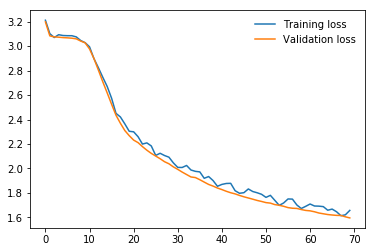

In [240]:
plt.figure()
plt.plot(losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)

## Making predictions

In [241]:
def predict(net, char, h=None, top_k=None):
        ''' Given a character, predict the next character.
            Returns the predicted character and the hidden state.
        '''
        
        # tensor inputs
        x = np.array([[net.char_index[char]]])
        x = one_hot_encode(x, len(net.chars))
        inputs = torch.from_numpy(x)
        
        if(train_on_gpu):
            inputs = inputs.cuda()
        
        # detach hidden state from history
        h = tuple([each.data for each in h])
        # get the output of the model
        out, h = net(inputs, h)

        # get the character probabilities
        p = F.softmax(out, dim=1).data
        if(train_on_gpu):
            p = p.cpu() # move to cpu
        
        # get top characters
        if top_k is None:
            top_ch = np.arange(len(net.chars))
        else:
            p, top_ch = p.topk(top_k)
            top_ch = top_ch.numpy().squeeze()
        
        # select the likely next character with some element of randomness
        p = p.numpy().squeeze()
        char = np.random.choice(top_ch, p=p/p.sum())
        
        # return the encoded value of the predicted char and the hidden state
        return net.index_char[char], h

In [242]:
def sample_characters(net, size, prime='The', top_k=None):
        
    if(train_on_gpu):
        net.cuda()
    else:
        net.cpu()
    
    net.eval() # eval mode
    
    # First off, run through the prime characters
    chars = [ch for ch in prime]
    h = net.init_hidden(1)
    for ch in prime:
        char, h = predict(net, ch, h, top_k=top_k)

    chars.append(char)
    
    # Now pass in the previous character and get a new one
    for ii in range(size):
        char, h = predict(net, chars[-1], h, top_k=top_k)
        chars.append(char)

    return ''.join(chars)

In [243]:
print(sample_characters(net, 100, prime='I love', top_k=5))

I love you wanting this  
And they gave me so mack to take you  
Take me helen  
  
The say to me a stoppin


In [244]:
def sample_words(net, size, prime='The', top_k=None):
        
    if(train_on_gpu):
        net.cuda()
    else:
        net.cpu()
    
    net.eval() # eval mode
    
    # First off, run through the prime characters
    chars = [ch for ch in prime]
    h = net.init_hidden(1)
    for ch in prime:
        char, h = predict(net, ch, h, top_k=top_k)

    chars.append(char)
    
    # Now pass in the previous character and get a new one
    while 1:
        char, h = predict(net, chars[-1], h, top_k=top_k)
        chars.append(char)
        if len(''.join(chars).split()) == size + 1:
            break;

    return ''.join(chars[:-2])

In [245]:
print(sample_words(net, 20, prime='Hello', top_k=5))

Hellonge  
  
That you're live in the strom on your hare  
It's arlay, then I wan talk anow won some  
In


In [246]:
def sample_lines(net, size, prime='The', top_k=None):
        
    if(train_on_gpu):
        net.cuda()
    else:
        net.cpu()
    
    net.eval() # eval mode
    
    # First off, run through the prime characters
    chars = [ch for ch in prime]
    h = net.init_hidden(1)
    for ch in prime:
        char, h = predict(net, ch, h, top_k=top_k)

    chars.append(char)
    
    # Now pass in the previous character and get a new one
    while (size > 0):
        char, h = predict(net, chars[-1], h, top_k=top_k)
        chars.append(char)        
        if char == '\n':
            size -= 1

    return ''.join(chars)

In [247]:
print(sample_lines(net, 15, prime='I love', top_k=5))

I love you wing they won't you to the trun  
I was that you say I'm good  
To my seeming say and me thit to be  
If'r thinkses who wancer to me to be  
It and the crows a minster alithe  
I gotto bod a stared and was allot man  
You've got the canders to me  
You're groust woreds  
In your lest all stream  
I get the tryer  
  
It's all the way  
If I ceard around you are  
The wonth the truss of simess this in  
A string all me aroughs  



## Saving the model

In [248]:
model_name = 'models/model1.pth'

checkpoint = {'n_hidden': net.n_hidden,
              'n_layers': net.n_layers,
              'state_dict': net.state_dict(),
              'tokens': net.chars}

with open(model_name, 'wb') as f:
    torch.save(checkpoint, f)

## Loading a model

In [249]:
with open('models/model1.pth', 'rb') as f:
    checkpoint = torch.load(f)
    
loaded = MyRNN(checkpoint['tokens'], n_hidden=checkpoint['n_hidden'], n_layers=checkpoint['n_layers'])
loaded.load_state_dict(checkpoint['state_dict'])